# ***Model - Ktrain***

### ***Installing Packages***

In [0]:
!pip install ktrain

### ***Importing packages***

In [0]:
import numpy as np
from tensorflow.keras import models
from tensorflow.keras.models import model_from_json
from tensorflow.keras.backend import get_session, set_session
from tensorflow.keras import backend as K
import pickle
import tensorflow as tf

from tensorflow.keras.models import model_from_json
import pickle

In [0]:
tf.__version__

'1.15.0'

### ***Training***

In [0]:
DATA_PATH = 'Category.csv'
NUM_WORDS = 50000
MAXLEN = 25000
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_csv(DATA_PATH,
                      'Sentences',
                      label_columns = cat_dummies.columns[:-1],
                      val_filepath=None, 
                      max_features=NUM_WORDS,
                      maxlen=MAXLEN,
                      encoding= 'utf-8')

language: en
Word Counts: 40027
Nrows: 25413
25413 train sequences
Average train sequence length: 24
x_train shape: (25413,25000)
y_train shape: (25413,151)
2824 test sequences
Average test sequence length: 23
x_test shape: (2824,25000)
y_test shape: (2824,151)


In [0]:
model = text.text_classifier('fasttext', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 25000
done.


In [0]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

simulating training for different learning rates... this may take a few moments...
Train on 25413 samples
Epoch 1/1024
25413/25413 [==============================] - 56s 2ms/sample - loss: 5.2551 - acc: 0.0073
Epoch 2/1024
25413/25413 [==============================] - 56s 2ms/sample - loss: 4.9004 - acc: 0.0436
Epoch 3/1024
 8384/25413 [========>.....................] - ETA: 37s - loss: 9.2332 - acc: 0.0064

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


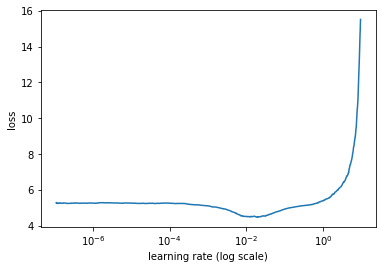

In [0]:
learner.lr_find()
learner.lr_plot()

In [0]:
learner.autofit(0.001)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 25413 samples, validate on 2824 samples
Epoch 1/1024
25413/25413 [==============================] - 58s 2ms/sample - loss: 4.8633 - acc: 0.0516 - val_loss: 4.2578 - val_acc: 0.2663
Epoch 2/1024
25413/25413 [==============================] - 58s 2ms/sample - loss: 4.1159 - acc: 0.1599 - val_loss: 3.2442 - val_acc: 0.4246
Epoch 3/1024
25413/25413 [==============================] - 57s 2ms/sample - loss: 3.4800 - acc: 0.2516 - val_loss: 2.6075 - val_acc: 0.5004
Epoch 4/1024
25413/25413 [==============================] - 57s 2ms/sample - loss: 3.0776 - acc: 0.3081 - val_loss: 2.2776 - val_acc: 0.5340
Epoch 5/1024
25413/25413 [==============================] - 57s 2ms/sample - loss: 2.8008 - acc: 0.3543 - val_loss: 2.0829 - val_acc: 0.5535
Epoch 6/1024
25413/25413 [==============================] - 57

#### **Saving Model** 

In [0]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [0]:
predictor.save('category')
print('*********************************MODEL SAVED***************************************************')

*********************************MODEL SAVED***************************************************


#### **Loading Model**

In [0]:
# Loading the model and assign it to the predictor
loaded_model = ktrain.load_predictor('category')

## **Saving and Loading Model - Deployment**

In [0]:
# Saving Model
model_json = learner.model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

learner.model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
def cat_init():
  # Load model json file
  json_file = open('model.json','r')

  # Load Ktrain preproc file
  features = pickle.load(open('model.preproc', 'rb'))
  
  # Session
  sess =K.get_session()
  graph = tf.get_default_graph()

  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)

  loaded_model.load_weights("model.h5")
  print("Model Loaded from disk")

  #compile and evaluate loaded model
  loaded_model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['acc'])
  return loaded_model,graph,sess,features

In [0]:
global cat_graph, cat_model, cat_sess, cat_features
cat_model, cat_graph, cat_sess, cat_features = cat_init()

using Keras version: 2.2.4-tf
Model Loaded from disk


In [0]:
def convertText(text):
	vector_text = cat_features.preprocess([text])
	return vector_text

In [0]:
query = 'i want to install ms office'

In [0]:
vec_query = convertText(query)
cat_classes = {0:'Hardware',1:'Network',2:'SAP Authorizations',3:'Software'}

# Category prediction
with cat_graph.as_default():
  set_session(cat_sess)
  vec_cat = cat_model.predict(vec_query)

cat_index = vec_cat[0].argmax(axis=0)

category = cat_classes[cat_index]
print({'Category':category})

{'Category': 'Software'}
